In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.constants import c
from scipy.signal import fftconvolve
from scipy.signal.windows import hamming, blackman, kaiser
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import csv
from funcs import read_iq_bin, notch_filter, gen_chirp_to_csv_rep, spectrogram_data, extract_signals_from_bin, read_complex_csv, gen_chirp_to_csv, gen_nlfm_to_csv
pulse_width = 5000
pulse_separation = 0
B = 12e6

2.0833333333333335


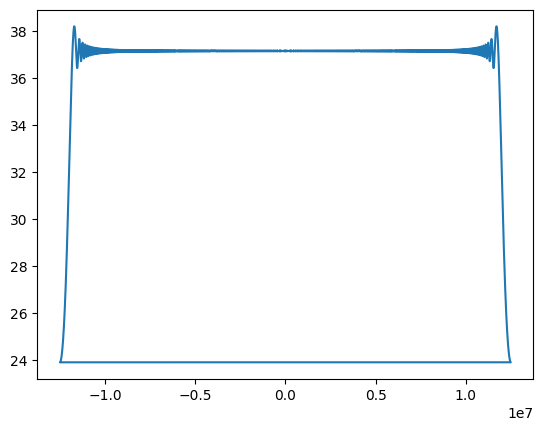

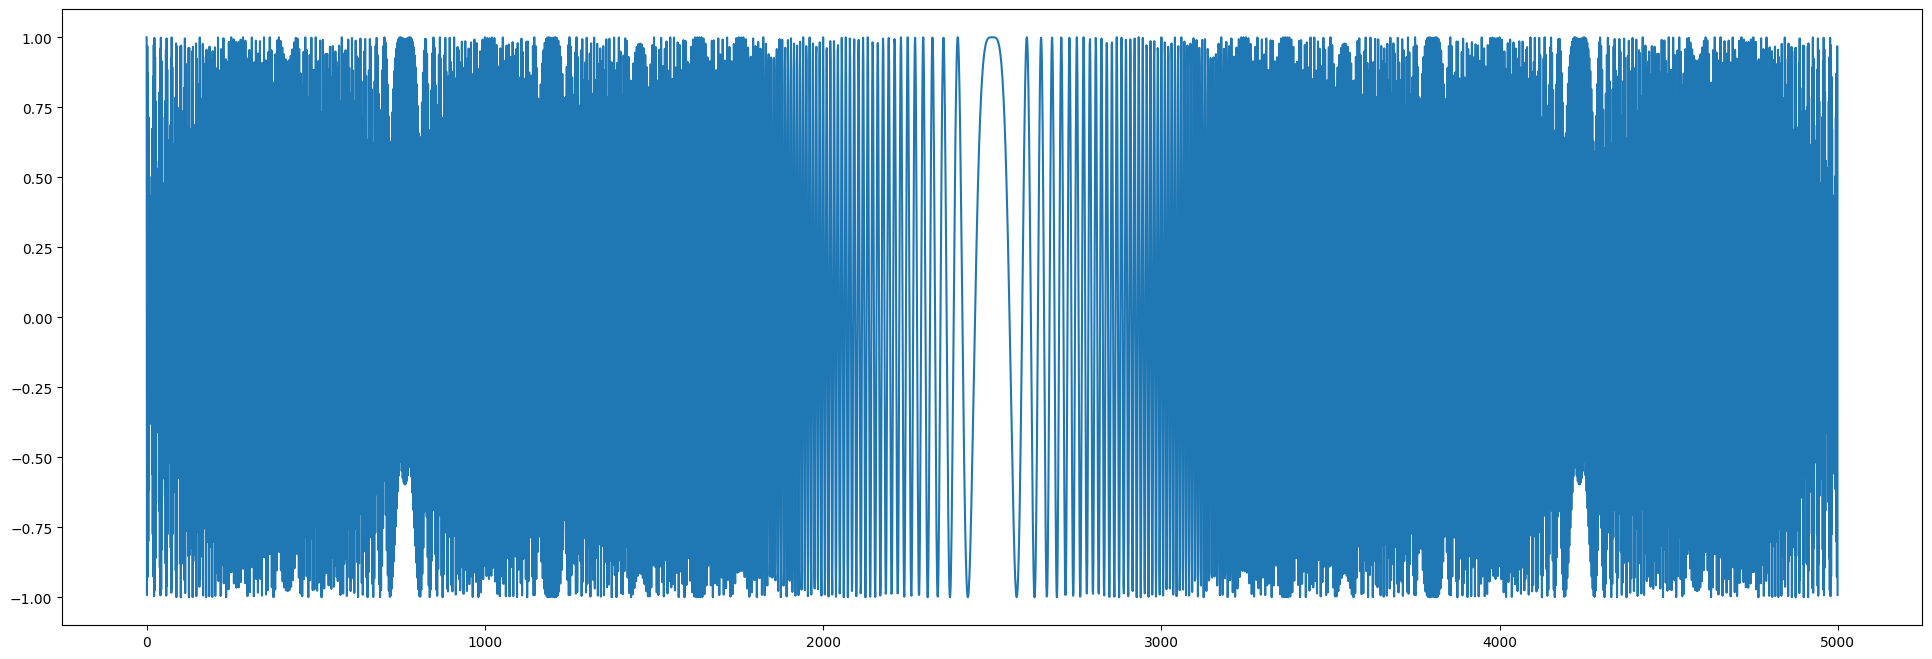

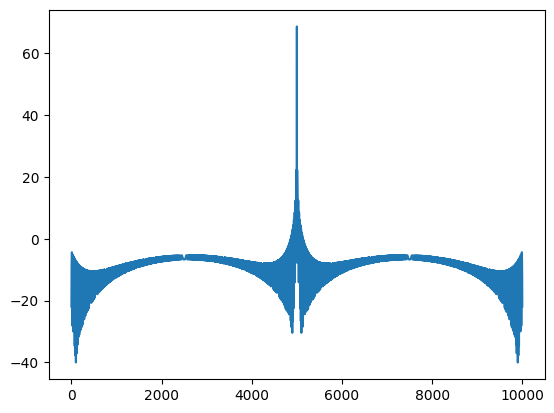

In [3]:
fs = 25e6

result = gen_chirp_to_csv("../sweep.csv", -B, B, pulse_width, pulse_separation, 1, fs)

# 3dB width delta t = 1/B
mlw = fs * 1/B
print(mlw)

fft_data = np.fft.fft(result)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)
plt.plot(fft_freq_axis, 20*np.log10(np.abs(fft_data)))
plt.show()

plt.figure(figsize=(24,8))
plt.plot(result[0:pulse_width])
plt.show()


template_signal=result[0:pulse_width]
matched_filter = np.conjugate(template_signal[::-1])
window = hamming(len(matched_filter))  # Choose the appropriate window function
matched_filter = matched_filter * window  # Apply the window
xcorr_data = fftconvolve(result[0:pulse_width], matched_filter, mode='full')
#xcorr_data = xcorr_data[5000:-5000] # Artifact at start
plt.plot(20*np.log10(np.abs(xcorr_data)))
plt.show()

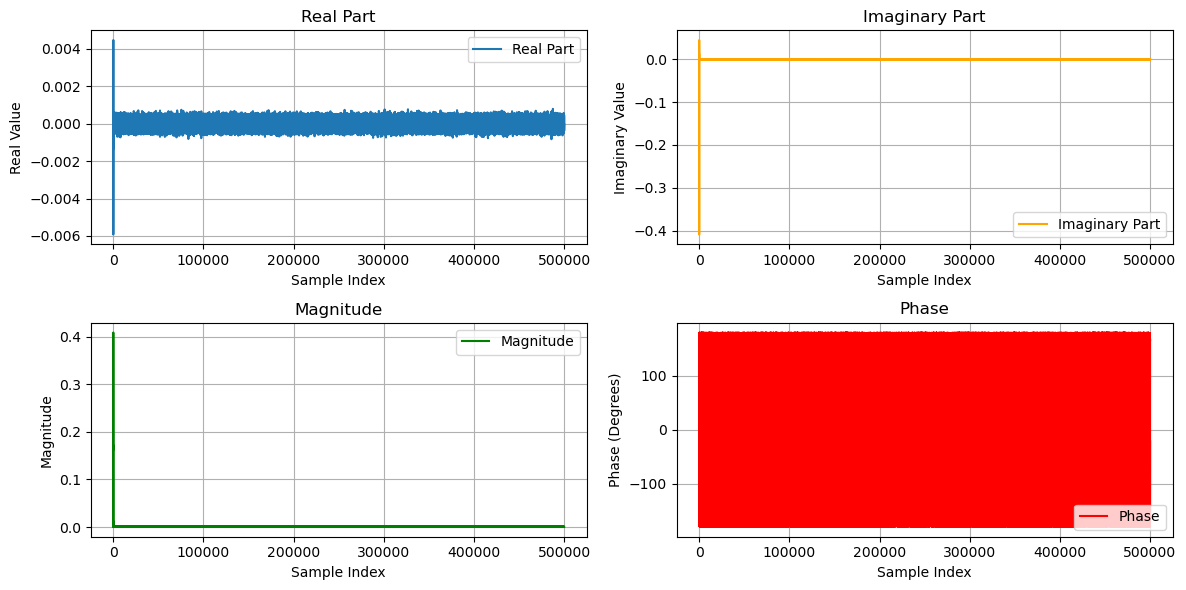

In [28]:
fs = 25e6

# Define the path to your binary file
file_path = '../outputs/pulsed_test.bin'


complex_data = read_iq_bin(file_path)
complex_data = notch_filter(complex_data, fs, 10, 0.1e6, 4)
#complex_data = median_filter_complex(complex_data,5)


# Compute magnitude and phase
magnitudes = np.abs(complex_data)
phases = np.angle(complex_data, deg=True)  # Phase in degrees

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot real part
real = np.real(complex_data)
#real = moving_average_filter(real,10)
axs[0, 0].plot(real, label='Real Part')
axs[0, 0].set_title('Real Part')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Real Value')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot imaginary part
axs[0, 1].plot(np.imag(complex_data), label='Imaginary Part', color='orange')
axs[0, 1].set_title('Imaginary Part')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Imaginary Value')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot magnitude
axs[1, 0].plot(magnitudes, label='Magnitude', color='green')
axs[1, 0].set_title('Magnitude')
axs[1, 0].set_xlabel('Sample Index')
axs[1, 0].set_ylabel('Magnitude')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot phase
axs[1, 1].plot(phases, label='Phase', color='red')
axs[1, 1].set_title('Phase')
axs[1, 1].set_xlabel('Sample Index')
axs[1, 1].set_ylabel('Phase (Degrees)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [4]:
file_path = '../outputs/pulsed_test.bin'
#file_path = "../outputs/outputs4/lab_cr_0.bin"
#file_path = "../outputs/outputs6/rx_test_hi.bin"
fs = 25e6


complex_data = read_iq_bin(file_path)
#complex_data = notch_filter(complex_data, fs, 10, 0.1e6, 2)
#complex_data = bandpass_filter(complex_data, 4.5e6, 7.5e6, fs, 4)

# Plotting spectrogram
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
times, frequencies_shifted, magnitude_spectrogram_db = spectrogram_data(complex_data,fs)
cax0 = axs[0].pcolormesh(times, frequencies_shifted, magnitude_spectrogram_db, shading='auto', cmap='plasma')
#axs[0].set_colorbar(label='Magnitude (dB)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Real Value')
axs[0].set_title('Spectrogram')

# plotting fft
fft_data = np.fft.fft(complex_data)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)

# convert to db
magnitude = np.abs(fft_data)
magnitude_db = 20 * np.log10(magnitude/np.max(magnitude))


axs[1].plot(fft_freq_axis, magnitude_db, label='FFT')
axs[1].set_title('FFT')
axs[1].legend()
axs[1].grid(True)

fig.colorbar(cax0, ax=axs[0])
plt.tight_layout()
plt.show()

plt.pcolormesh(times, frequencies_shifted, magnitude_spectrogram_db, shading='auto', cmap='plasma')
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Spectrogram")
plt.show()

plt.plot(fft_freq_axis, magnitude_db, label='FFT')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("FFT")
plt.grid()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../outputs/pulsed_test.bin'

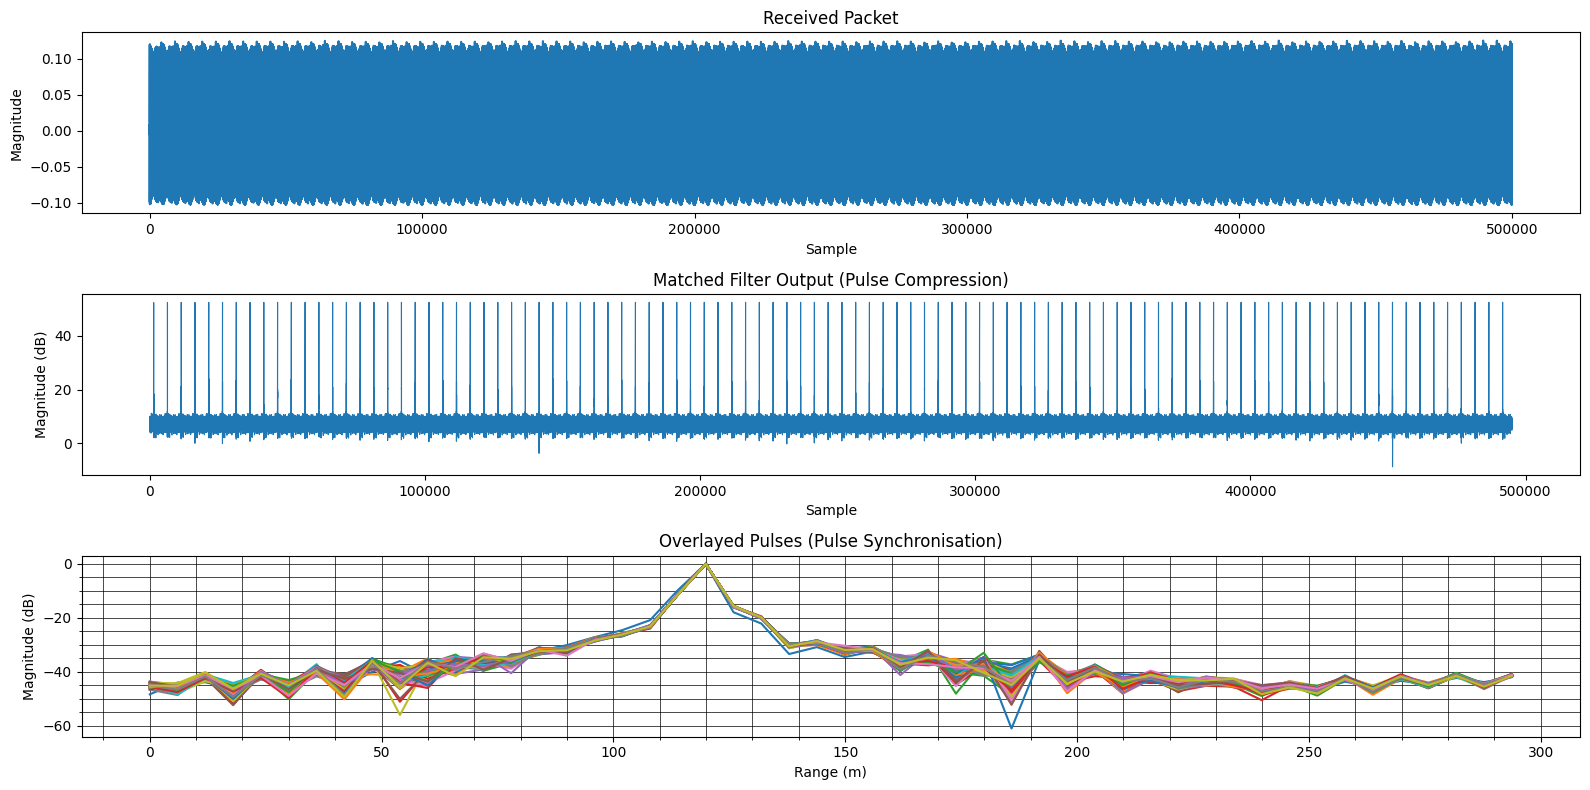

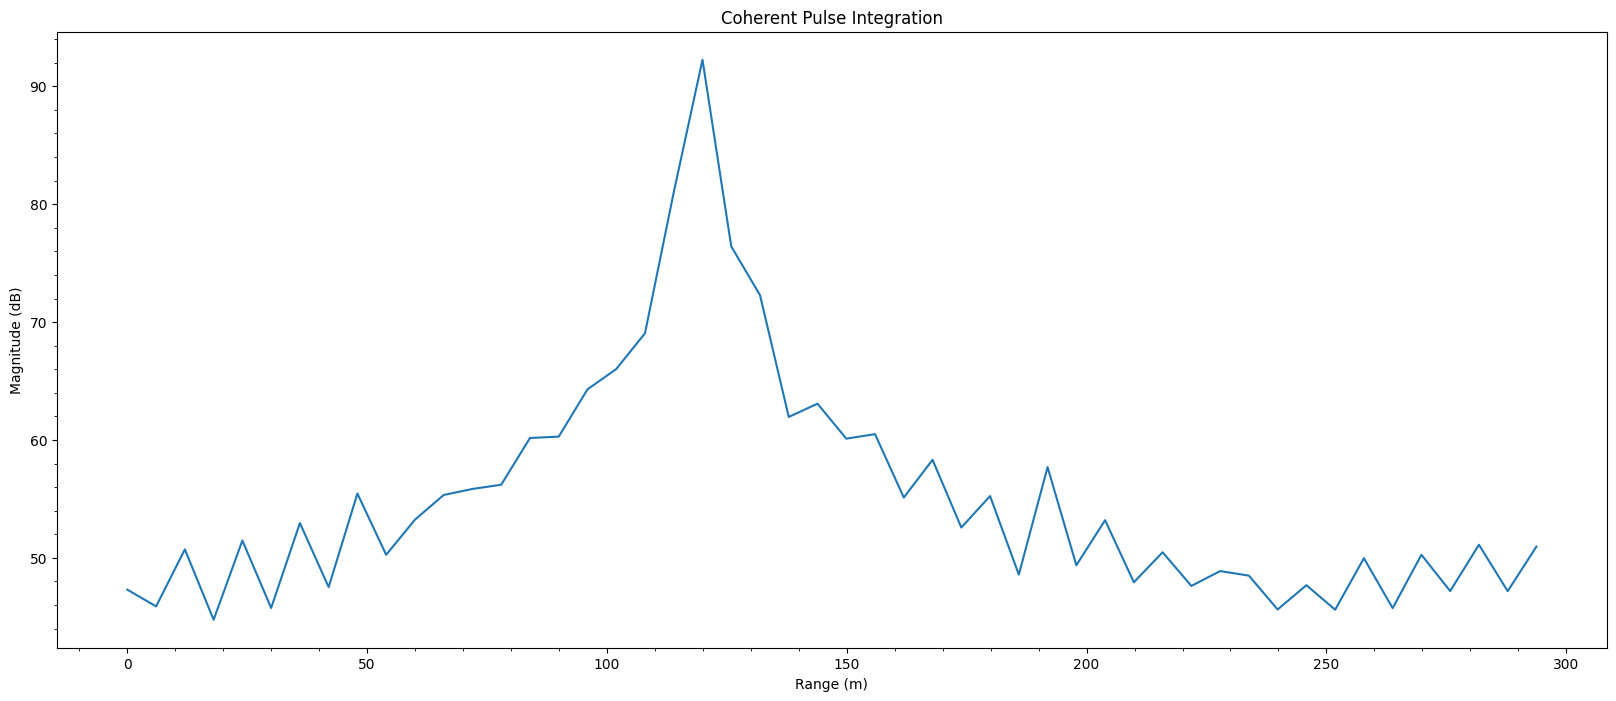

99


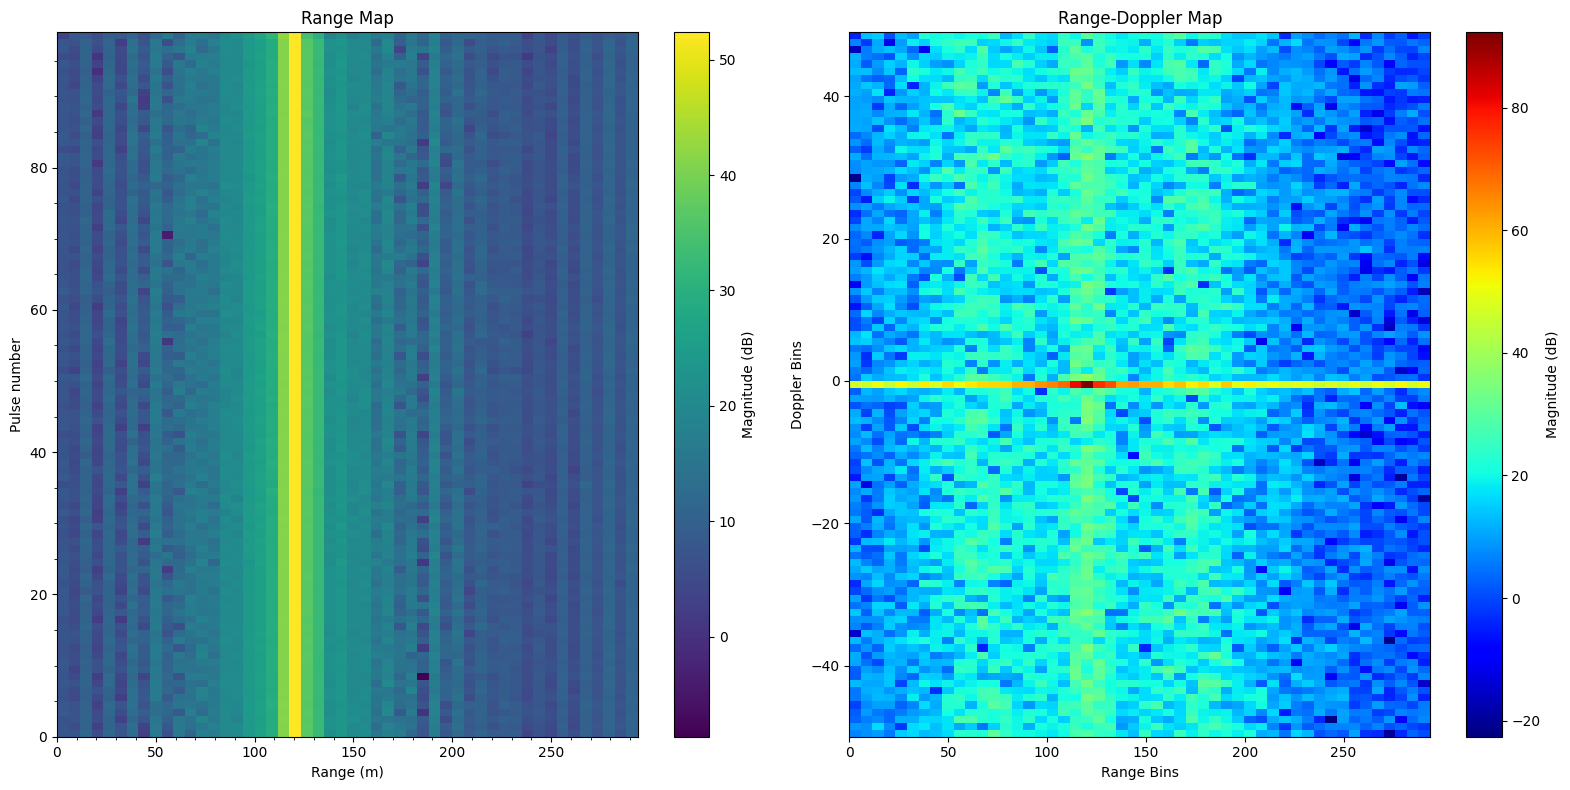

In [7]:
data = read_iq_bin("../outputs/outputs5/field_cr_25m_1.bin")
#data = read_iq_bin("../outputs/pulsed_test.bin")
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
#data = data[50000:]

fig, axs = plt.subplots(3, 1, figsize=(16, 8))

axs[0].plot(data)
axs[0].set_title("Received Packet")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Magnitude")

# Matched filter
matched_filter = np.conjugate(template_signal[::-1])
window = hamming(len(matched_filter))  # Choose the appropriate window function
window = kaiser(len(matched_filter), 2, sym=True)  # Choose the appropriate window function
matched_filter = matched_filter * window  # Apply the window
xcorr_data = fftconvolve(data, matched_filter, mode='full')
xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full
axs[1].plot(20*np.log10(np.abs(xcorr_data)),linewidth=0.8)
axs[1].set_title("Matched Filter Output (Pulse Compression)")
axs[1].set_xlabel("Sample")
axs[1].set_ylabel("Magnitude (dB)")

# Extract pulses
xcorr_matrix = []
ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:50]
pulse_sum = np.zeros(50).astype(np.complex128)
while (len(xcorr_data)>0):
    max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
    xcorr_data_plot = xcorr_data[max_idx-20:max_idx+pulse_width]
    xcorr_data_plot = xcorr_data_plot[0:50]
    if (len(xcorr_data_plot)==50):
        axs[2].plot(ranges,20*np.log10(np.abs(xcorr_data_plot/np.max(xcorr_data_plot))))
        pulse_sum += xcorr_data_plot
        xcorr_data = xcorr_data[pulse_width+pulse_separation:]
        xcorr_matrix.append(xcorr_data_plot)
    else:
        break

#axs[2].set_xticks(ranges)
axs[2].grid(True, which='both')
axs[2].grid(which='minor', linewidth=0.5, color='black')
axs[2].grid(which='major', linewidth=0.5, color='black')
axs[2].minorticks_on()
#plt.setp(axs[2].get_xticklabels(), fontsize=4)
axs[2].set_title("Overlayed Pulses (Pulse Synchronisation)")
axs[2].set_xlabel("Range (m)")
axs[2].set_ylabel("Magnitude (dB)")

plt.tight_layout()
plt.show()

plt.figure(figsize=(20,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum)))
plt.minorticks_on()
plt.title("Coherent Pulse Integration")
plt.xlabel("Range (m)")
plt.ylabel("Magnitude (dB)")
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Range map
im_range = axs[0].imshow(20*np.log10(np.abs(xcorr_matrix)), extent=[ranges[0], ranges[-1], 0, len(xcorr_matrix)], aspect='auto', cmap='viridis') 
axs[0].minorticks_on()
axs[0].set_ylabel("Pulse number")
axs[0].set_xlabel("Range (m)")
axs[0].set_title("Range Map")


# Range-doppler
num_pulses = len(xcorr_matrix)
print(num_pulses)
num_range_bins = len(xcorr_matrix[0])

doppler_fft = np.fft.fftshift(np.fft.fft(xcorr_matrix, axis=0), axes=0)
range_doppler_map = 20 * np.log10(np.abs(doppler_fft))

im_rd = axs[1].imshow(range_doppler_map, extent=[ranges[0], ranges[-1], -num_pulses//2, num_pulses//2],
           aspect='auto', cmap='jet', origin='lower')
axs[1].set_title('Range-Doppler Map')
axs[1].set_xlabel('Range Bins')
axs[1].set_ylabel('Doppler Bins')

cbar = plt.colorbar(im_range, ax=axs[0])
cbar.set_label('Magnitude (dB)')  # Set the label for the colorbar
cbar = plt.colorbar(im_rd, ax=axs[1])
cbar.set_label('Magnitude (dB)')  # Set the label for the colorbar
plt.tight_layout()
plt.show()


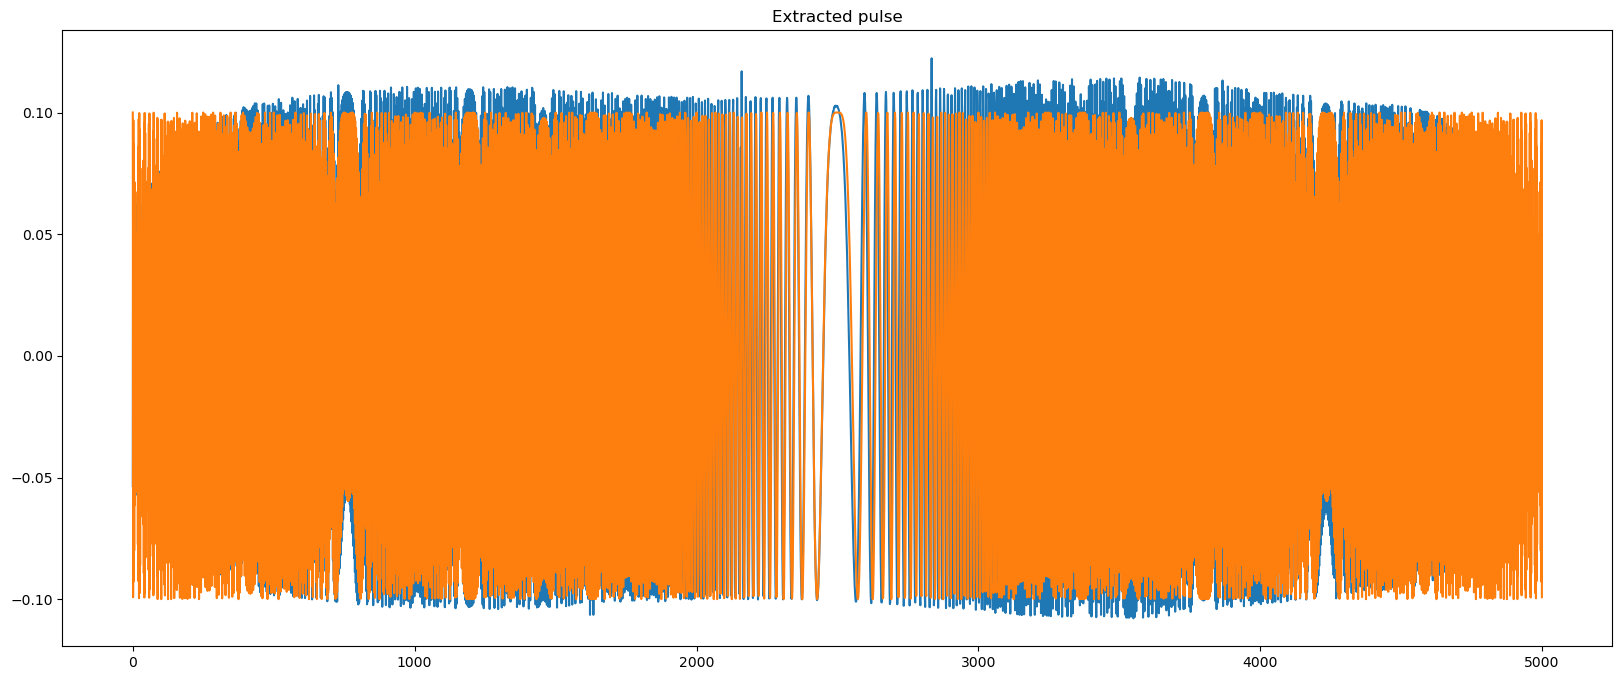

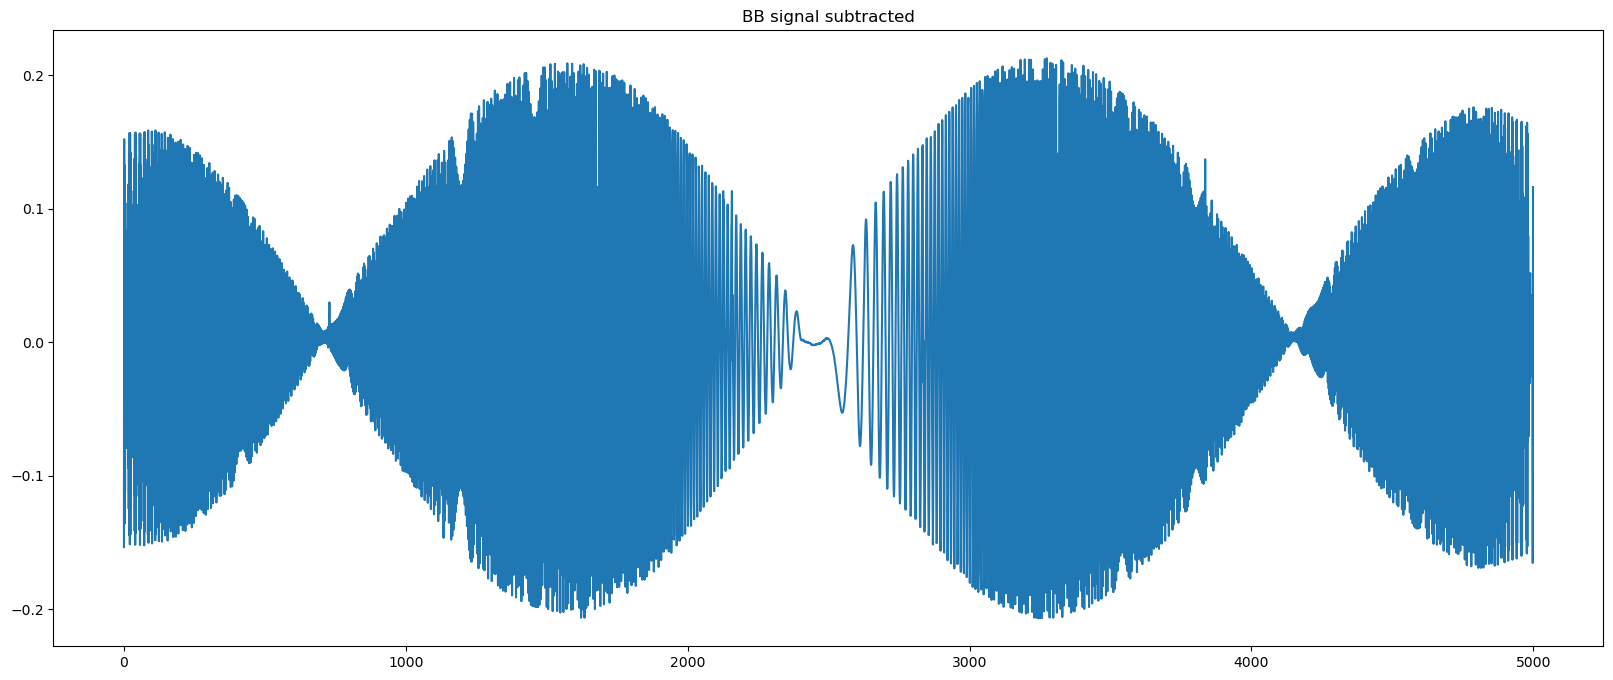

'\n# Extract pulses\nxcorr_matrix = []\nranges = np.arange(len(template_signal)) * c / (2*25e6)\nranges = ranges[0:50]\npulse_sum = np.zeros(50).astype(np.complex128)\nwhile (len(xcorr_data)>0):\n    max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))\n    signal_xtalk_removed = data[max_idx:max_idx+pulse_width] - 0.1*template_signal\n    xcorr_data_plot = fftconvolve(signal_xtalk_removed, matched_filter, mode=\'full\')\n    xcorr_data_plot = xcorr_data_plot[len(xcorr_data_plot)//2:]\n    xcorr_data_plot = xcorr_data_plot[0:50]\n    if (len(xcorr_data_plot)==50):\n        axs[2].plot(ranges,20*np.log10(np.abs(xcorr_data_plot/np.max(xcorr_data_plot))))\n        pulse_sum += xcorr_data_plot\n        xcorr_data = xcorr_data[pulse_width+pulse_separation:]\n        xcorr_matrix.append(xcorr_data_plot)\n    else:\n        break\n\n#axs[2].set_xticks(ranges)\naxs[2].grid(True, which=\'both\')\naxs[2].grid(which=\'minor\', linewidth=0.5, color=\'black\')\naxs[2].grid(which=

In [2]:
data = read_iq_bin("../outputs/outputs5/field_cr_75m_0.bin")
#data = read_iq_bin("../outputs/pulsed_test.bin")
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
#data = data[50000:]


# Matched filter
matched_filter = np.conjugate(template_signal[::-1])
window = hamming(len(matched_filter))  # Choose the appropriate window function
window = kaiser(len(matched_filter), 20, sym=True)  # Choose the appropriate window function
matched_filter = matched_filter * window  # Apply the window
xcorr_data = fftconvolve(data, matched_filter, mode='full')
xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full
data = data[5000:-5000]



max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))+6
signal_xtalk_removed = data[max_idx:max_idx+pulse_width]
plt.figure(figsize=(20,8))
plt.plot(signal_xtalk_removed)
plt.plot(0.1*template_signal)
plt.title("Extracted pulse")
plt.show()

signal_xtalk_removed = signal_xtalk_removed - 0.1*template_signal
plt.figure(figsize=(20,8))
plt.plot(signal_xtalk_removed)
plt.title("BB signal subtracted")
plt.show()
"""
# Extract pulses
xcorr_matrix = []
ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:50]
pulse_sum = np.zeros(50).astype(np.complex128)
while (len(xcorr_data)>0):
    max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
    signal_xtalk_removed = data[max_idx:max_idx+pulse_width] - 0.1*template_signal
    xcorr_data_plot = fftconvolve(signal_xtalk_removed, matched_filter, mode='full')
    xcorr_data_plot = xcorr_data_plot[len(xcorr_data_plot)//2:]
    xcorr_data_plot = xcorr_data_plot[0:50]
    if (len(xcorr_data_plot)==50):
        axs[2].plot(ranges,20*np.log10(np.abs(xcorr_data_plot/np.max(xcorr_data_plot))))
        pulse_sum += xcorr_data_plot
        xcorr_data = xcorr_data[pulse_width+pulse_separation:]
        xcorr_matrix.append(xcorr_data_plot)
    else:
        break

#axs[2].set_xticks(ranges)
axs[2].grid(True, which='both')
axs[2].grid(which='minor', linewidth=0.5, color='black')
axs[2].grid(which='major', linewidth=0.5, color='black')
axs[2].minorticks_on()
#plt.setp(axs[2].get_xticklabels(), fontsize=4)
axs[2].set_title("Overlayed Pulses (Pulse Synchronisation)")
axs[2].set_xlabel("Range (m)")
axs[2].set_ylabel("Magnitude (dB)")

plt.tight_layout()
plt.show()

plt.figure(figsize=(20,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum)))
plt.minorticks_on()
plt.title("Coherent Pulse Integration")
plt.xlabel("Range (m)")
plt.ylabel("Magnitude (dB)")
plt.show()
"""




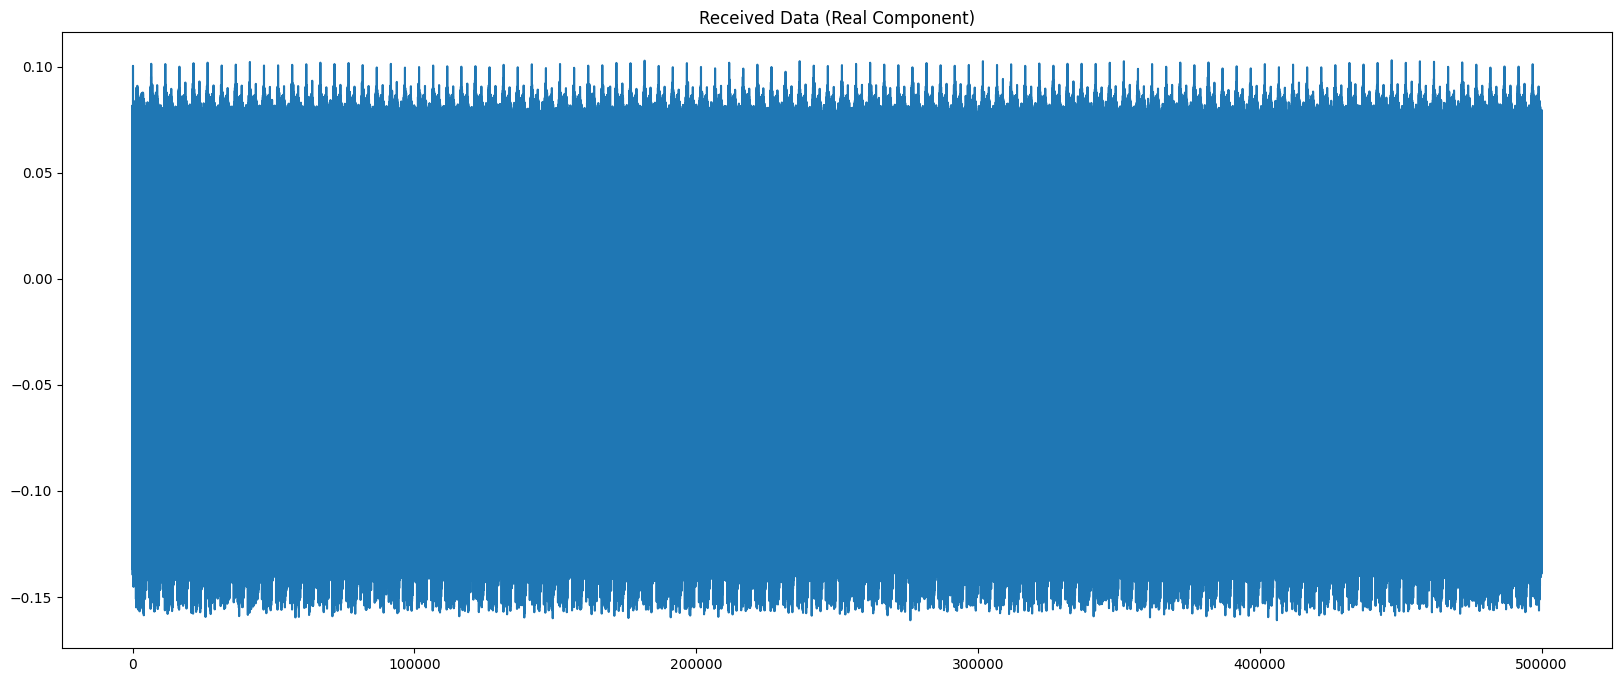

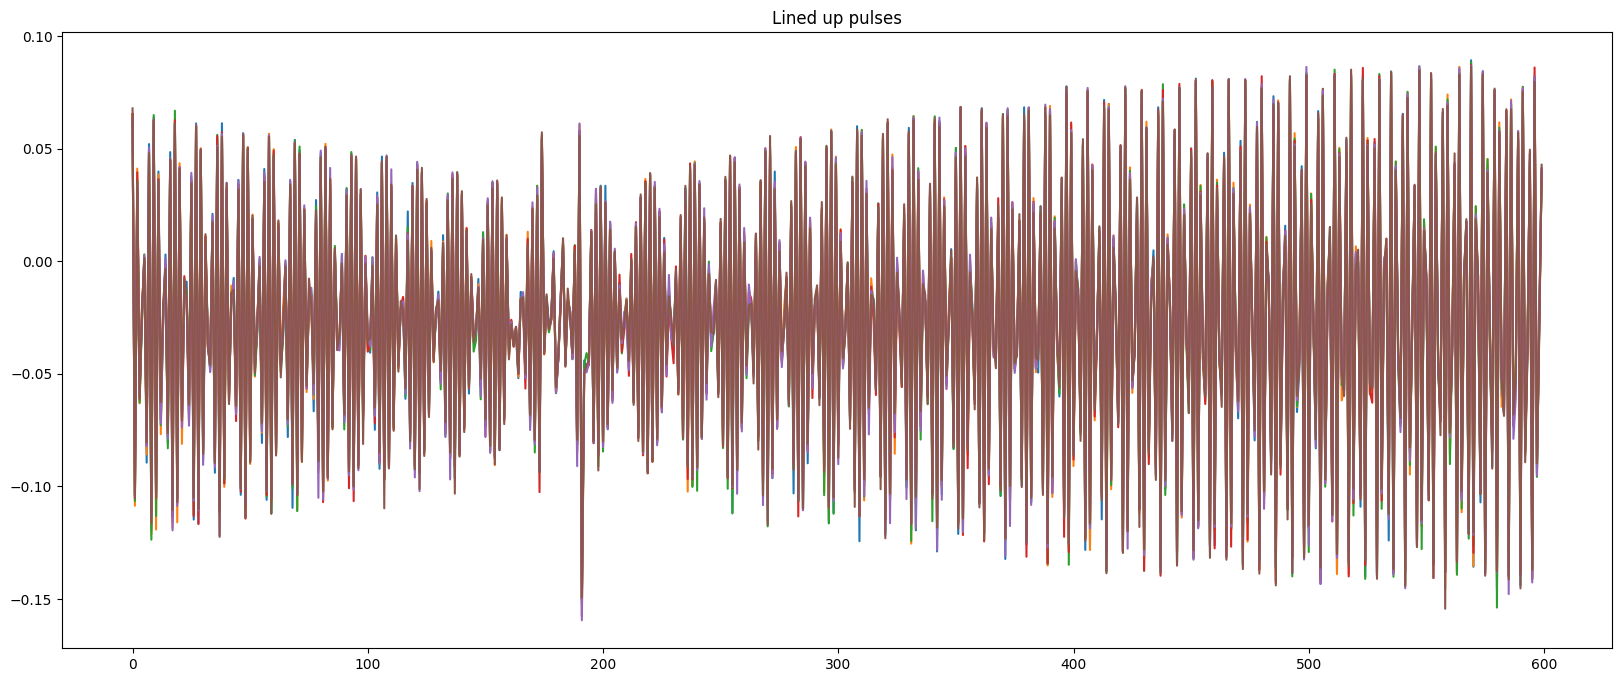

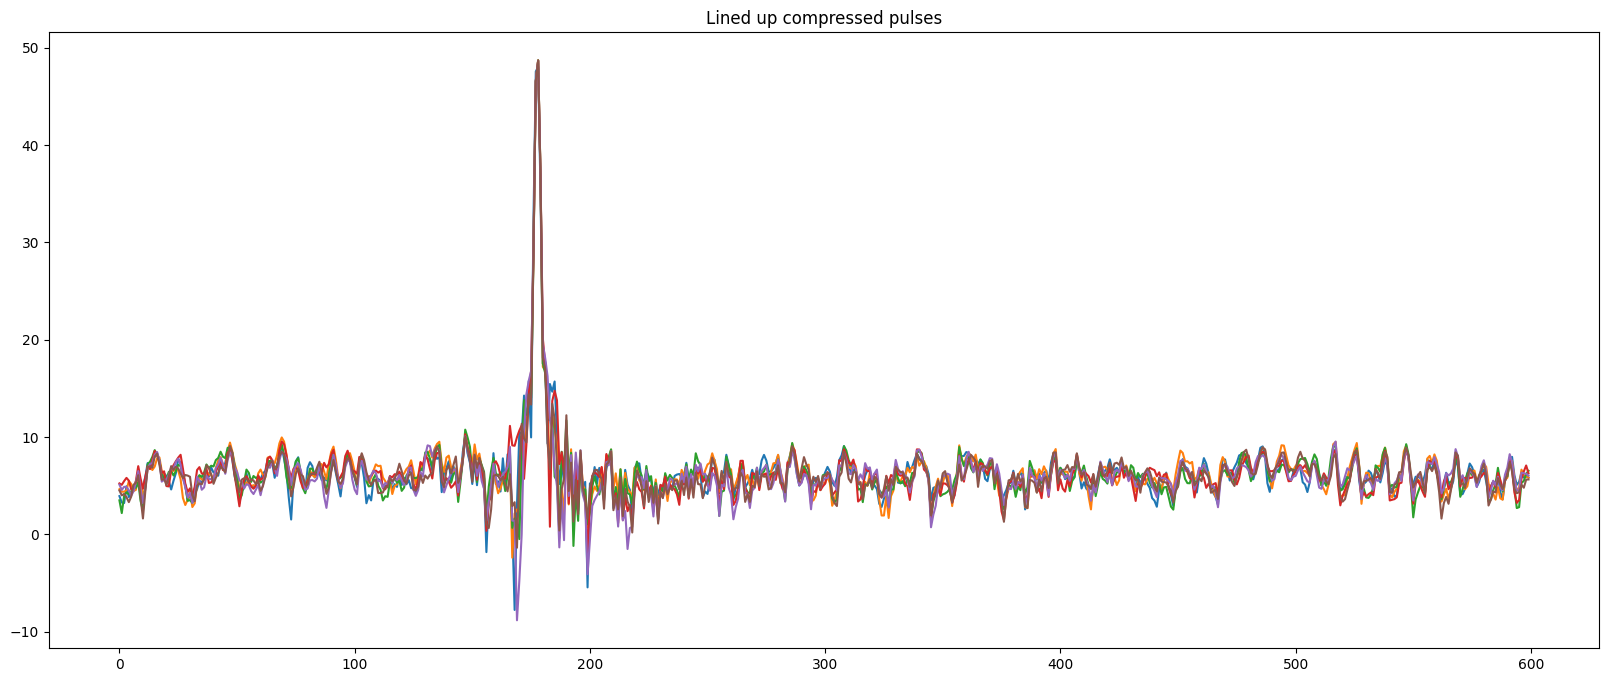

In [218]:
data = read_iq_bin("../outputs/pulsed_test.bin")
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
#data = data[50000:]
plt.figure(figsize=(20,8))
plt.plot(data)
plt.title("Received Data (Real Component)")
plt.show()


plt.figure(figsize=(20,8))
start_idx = 5700
end_idx = 6300
for i in range(6):
    n = (pulse_width+pulse_separation)*i+start_idx
    m = (pulse_width+pulse_separation)*i+end_idx
    start_idx = start_idx+2
    end_idx=end_idx+2
    plt.plot(data[n:m])
plt.title("Lined up pulses")
plt.show()

# Matched filter
matched_filter = np.conjugate(template_signal[::-1])
window = hamming(len(matched_filter))  # Choose the appropriate window function
matched_filter = matched_filter * window  # Apply the window
xcorr_data = fftconvolve(data, matched_filter, mode='full')
#xcorr_data = xcorr_data[5000:-5000] # Artifact at start
peak_idx = np.argmax(np.abs(xcorr_data[0:7500]))


plt.figure(figsize=(20,8))
for i in range(6):
    n = (pulse_width+pulse_separation)*i+start_idx
    m = (pulse_width+pulse_separation)*i+end_idx
    start_idx = start_idx+2
    end_idx=end_idx+2
    plt.plot(20*np.log10(np.abs(xcorr_data[n:m])))
plt.title("Lined up compressed pulses")
plt.show()



# FMCW

34
expected f_beat=50034614.27972281


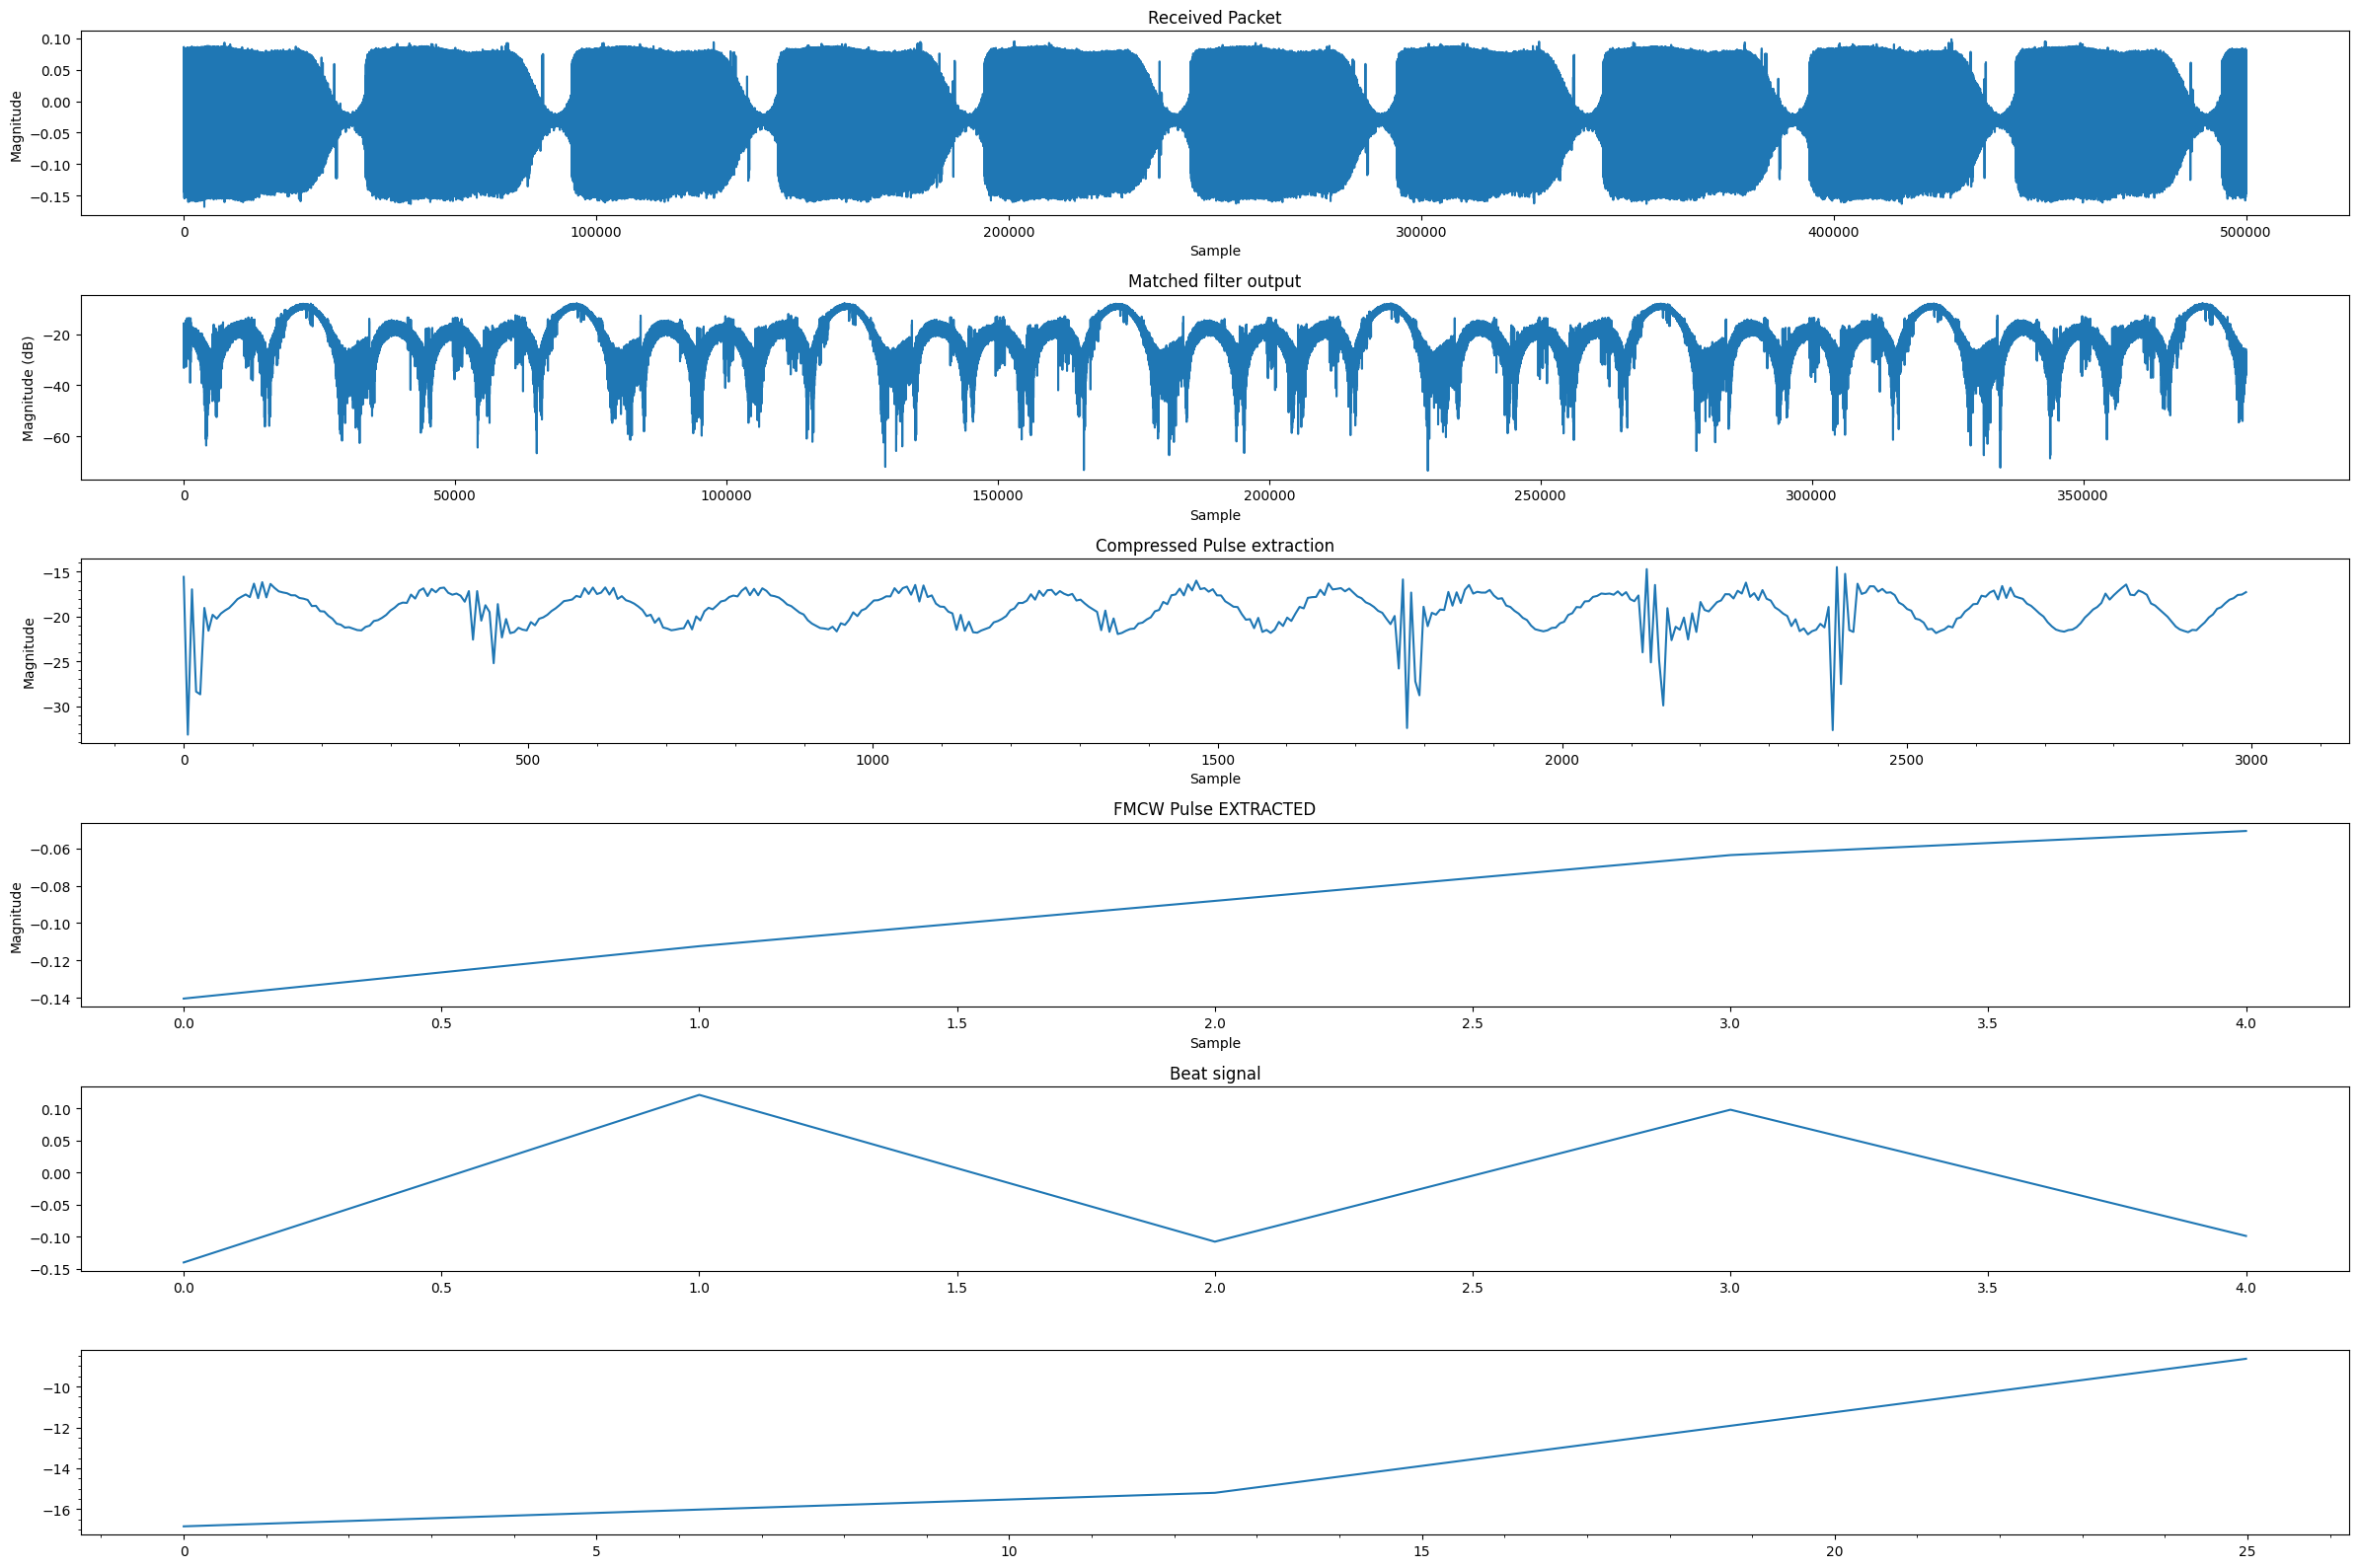

In [173]:
fs = 25e6

data = read_iq_bin("../outputs/pulsed_test.bin")
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
#data = data[50000:]

fig, axs = plt.subplots(6, 1, figsize=(24, 16))

# Received packet plot
axs[0].plot(data)
axs[0].set_title("Received Packet")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Magnitude")

# Matched filter 
matched_filter = np.conjugate(template_signal[::-1])
xcorr_data = fftconvolve(data, matched_filter, mode='full')
xcorr_data = xcorr_data[60000:-60000] #xcorr artifacts at start and end
data = data[60000:-60000]
axs[1].plot(20*np.log10(np.abs(xcorr_data)))
axs[1].set_title("Matched filter output")
axs[1].set_xlabel("Sample")
axs[1].set_ylabel("Magnitude (dB)")

# Pulse extraction
# First max index to see where CW has started
max_idx = np.argmax(xcorr_data[:pulse_width +pulse_separation])
print(max_idx)
xcorr_plot = 20*np.log10(np.abs(xcorr_data[max_idx:max_idx+500]))
ranges_xcorr = np.arange(len(xcorr_plot)) * c / (2*25e6)
axs[2].plot(ranges_xcorr,xcorr_plot)
#axs[2].plot(data[max_idx:max_idx+pulse_width])
axs[2].set_title("Compressed Pulse extraction")
axs[2].set_xlabel("Sample")
axs[2].set_ylabel("Magnitude")
axs[2].minorticks_on()

extracted = data[max_idx+pulse_separation:max_idx+pulse_separation+pulse_width]

axs[3].plot(extracted)
axs[3].set_title("FMCW Pulse EXTRACTED")
axs[3].set_xlabel("Sample")
axs[3].set_ylabel("Magnitude")

# Beat signal
beat_signal = extracted * np.conj(template_signal) 
axs[4].plot(beat_signal)
axs[4].set_title("Beat signal")


# FFT for beat frequency
fft_data = np.fft.fft(beat_signal)
fft_freqs = np.fft.fftfreq(len(beat_signal),1/fs)
fft_db = 20*np.log10(np.abs(fft_data))
#axs[3].plot(fft_freqs,fft_db)

midpt = len(fft_freqs)//2
fft_freqs = fft_freqs[:-midpt]
fft_data = fft_data[:-midpt]
fft_db = fft_db[:-midpt]
end_idx = 50
fft_freqs = fft_freqs[:end_idx]
fft_db = fft_db[:end_idx]
fft_data = fft_data[:-end_idx]

dR = c/(2*B)
ranges_fft = fft_freqs*dR*pulse_width/fs
#axs[5].plot(fft_freqs,fft_db)
axs[5].plot(ranges_fft,fft_db)
axs[5].minorticks_on()

dF = B
T = pulse_width/fs
K = dF/T
d = 125
f_beat = K * 2*d/c
print(f"expected f_beat={f_beat}")



max_idx = np.argmax(fft_db)
#print(f"Extracted f_beat={max_idx}")
d = dR*max_idx
#print(f"d={d}")


plt.tight_layout()
plt.show()